In [55]:
import medleydb as mdb
import mir_eval

import os
import numpy as np
import scipy
import csv
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
F_THRESH = 0.8/12.0
MIN_CONTOUR_LEN = 0.02

HOP = 256.0  # Tony default hop size
FS = 44100.0  # Tony default output sample rate

SR = FS/HOP
# HOP = (1.0/SR) + 0.0001 

In [7]:
256.0/44100.0

0.005804988662131519

In [9]:
def get_time_stamps(total_duration):
    """Get a list of evenly spaced time stamps based on Tony's parameters.

    Parameters
    ----------
    total_duration : float
        Length (in seconds) of annotation's corresponding audio file.

    Returns
    -------
    time_stamps : array
        Array of evenly spaced time stamps spanning the entire annotation.
    """
    n_stamps = int(np.ceil((total_duration*FS)/HOP))
    return np.arange(n_stamps)*(HOP/FS)


def make_blank_f0_sequence(total_duration):
    """Make a complete f0 sequence filled with 0's.
    First column is time, second column is frequency.

    Parameters
    ----------
    total_duration : float
        Length (in seconds) of annotation's corresponding audio file.

    Returns
    -------
    f0_sequence : array
        Array of filled in f0 values and corresponding time stamps.
    """
    time_stamps = get_time_stamps(total_duration)
    f0_sequence = np.zeros((len(time_stamps), 2))
    f0_sequence[:, 0] = time_stamps
    return f0_sequence


def sec_to_idx(time_in_seconds, sample_rate=FS, hop=HOP):
    """Compute the array index of a given time stamp.

    Parameters
    ----------
    time_in_seconds : float
        Time stamp, in seconds.
    sample_rate : float
        Annotation sample rate.
    hop : float
        Annotation hop size.

    Returns
    -------
    array_idx : int
        Index of time stamp in filled f0 array.
    """
    return int(np.round(time_in_seconds*sample_rate/hop))

In [18]:
def get_confidence_interpolator(mtrack, stem_idx):
    conf = np.array(mtrack.activation_conf_from_stem(stem_idx)).T
    conf_interp = scipy.interpolate.interp1d(
        conf[0], conf[1], fill_value=0, assume_sorted=True,
        bounds_error=False
    )
    return conf_interp

In [56]:
def fill_annotation(pitch_annotation, duration,
                    confidence_interpolator, activation_filter,
                    conf_thresh=0.5):
    if duration is None:
        duration = np.max(np.array(pitch_annotation).T[0])

    start_idx = sec_to_idx(0)
    end_idx = sec_to_idx(duration)
    f0_sequence = make_blank_f0_sequence(duration)
    for time_freq in pitch_annotation:
        time = time_freq[0]
        if activation_filter:
            conf = confidence_interpolator(time)
            freq = time_freq[1] if conf >= conf_thresh else 0.0
        else:
            freq = time_freq[1]

        time_idx = sec_to_idx(time)
        if time_idx >= start_idx and time_idx < end_idx:
            f0_sequence[time_idx][1] = freq
    f0_sequence = np.array(f0_sequence)
    f0_sequence = f0_sequence.T
    times = f0_sequence[0]
    freqs = f0_sequence[1]
    return times, freqs

In [68]:
def score_pyin_est(mtrack, activation_filter=True, make_plot=False, conf_thresh=0.5):
    all_scores = []
    for stem in mtrack.stems.values():
        if not (os.path.exists(stem.pitch_path) and os.path.exists(stem.pitch_pyin_path)):
            continue
        else:
            conf_interp = get_confidence_interpolator(mtrack, stem.stem_idx)

            ref_times, ref_freqs = fill_annotation(
                stem.pitch_annotation, mtrack.duration,
                conf_interp, activation_filter, conf_thresh=conf_thresh
            )
            est_times, est_freqs = fill_annotation(
                stem.pitch_estimate_pyin, mtrack.duration,
                conf_interp, activation_filter, conf_thresh=conf_thresh
            )

            if make_plot:
                plt.title(stem.instrument)
                plt.plot(ref_times, ref_freqs, '.b')
                plt.plot(est_times, est_freqs, ',r')
                plt.show()

            scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
            all_scores.append(scores)

    return all_scores

In [79]:
mtracks = mdb.load_all_multitracks("V1")

all_scores_activation_filter = []
all_scores_activation_superfilter = []
all_scores_no_filter = []
for mtrack in mtracks:
    if mtrack.has_bleed:
        continue

    print(mtrack.track_id)
    scores_filter = score_pyin_est(mtrack, activation_filter=True)
    scores_superfilter = score_pyin_est(mtrack, activation_filter=True, conf_thresh=1.0)
    scores_no_filter = score_pyin_est(mtrack, activation_filter=False)

    all_scores_activation_filter.extend(scores_filter)
    all_scores_activation_superfilter.extend(scores_superfilter)
    all_scores_no_filter.extend(scores_no_filter)

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_BluesForNofi
EthanHein_GirlOnABridge
EthanHein_HarmonicaFigure
FacesOnFilm_WaitingForGa
Grants_PunchDrunk
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_Rainfall
Lushlife_ToynbeeSuite
MatthewEntwistle_AnEveningWithOliver
MatthewEntwistle_DontYouEver
MatthewEntwistle_FairerHopes
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheArch
MatthewEntwistle_TheFlaxenField
Meaxic_TakeAStep
Meaxic_You

In [77]:
df_filter = pd.DataFrame(all_scores_activation_filter)
df_superfilter = pd.DataFrame(all_scores_activation_superfilter)
df_nofilter = pd.DataFrame(all_scores_no_filter)

In [61]:
df_filter.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.765650,0.827155,0.802743,0.323083,0.883843
std,0.134714,0.214267,0.241030,0.185133,0.221225
min,0.254453,0.054427,0.000000,0.009489,0.103844
25%,0.704880,0.812712,0.783175,0.206188,0.916741
50%,0.800780,0.901580,0.890261,0.298518,0.977087
75%,0.848195,0.959467,0.956129,0.432608,0.989691
max,0.985503,0.992760,0.992308,0.872838,1.000000


In [63]:
df_superfilter.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.777635,0.827096,0.802647,0.294168,0.883794
std,0.131587,0.214426,0.241305,0.172850,0.221451
min,0.261874,0.054427,0.000000,0.007798,0.103844
25%,0.708818,0.812712,0.782994,0.190660,0.917149
50%,0.807667,0.901478,0.891489,0.275192,0.977087
75%,0.863189,0.959412,0.956129,0.370337,0.989691
max,0.986751,0.992760,0.992308,0.832202,1.000000


In [62]:
df_nofilter.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.717896,0.827138,0.802725,0.414240,0.884035
std,0.143905,0.214265,0.241029,0.205651,0.220506
min,0.239610,0.054427,0.000000,0.021235,0.103844
25%,0.633791,0.812712,0.783194,0.273799,0.916741
50%,0.757816,0.901580,0.890337,0.414970,0.977087
75%,0.806203,0.959467,0.956129,0.557119,0.989691
max,0.975918,0.992760,0.992308,0.880809,1.000000


In [64]:
df_superfilter

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
0,0.816928,0.911952,0.907703,0.254176,0.979857
1,0.942518,0.963588,0.963102,0.065678,0.984950
2,0.868899,0.985002,0.985002,0.284622,0.998576
3,0.755866,0.514828,0.506813,0.040063,0.689564
4,0.839442,0.814942,0.812968,0.142406,0.957633
5,0.820110,0.830641,0.827945,0.187746,0.942321
6,0.764943,0.892696,0.856477,0.316543,0.968139
7,0.871144,0.890391,0.885885,0.135945,0.972819
8,0.801864,0.922325,0.920677,0.270536,0.968908
9,0.627333,0.884932,0.794977,0.591949,0.978695


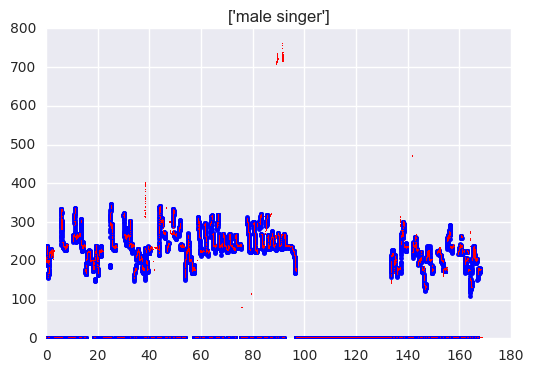

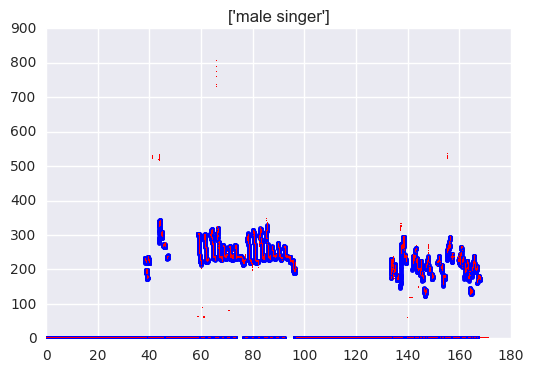

[OrderedDict([('Voicing Recall', 0.97985679439767093),
              ('Voicing False Alarm', 0.2896764252696456),
              ('Raw Pitch Accuracy', 0.90770320245495317),
              ('Raw Chroma Accuracy', 0.91195215988669442),
              ('Overall Accuracy', 0.79702080597221259)]),
 OrderedDict([('Voicing Recall', 0.98494962980944289),
              ('Voicing False Alarm', 0.071766866421805534),
              ('Raw Pitch Accuracy', 0.96310231824250514),
              ('Raw Chroma Accuracy', 0.96358781405510374),
              ('Overall Accuracy', 0.93816321592755181)])]

In [69]:
mtrack = mdb.MultiTrack('AClassicEducation_NightOwl')
score_pyin_est(mtrack, activation_filter=True, make_plot=True, conf_thresh=0.5)

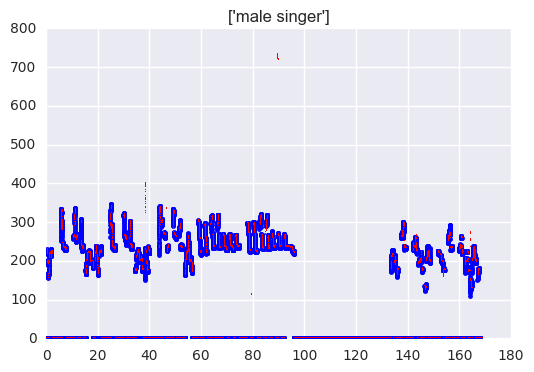

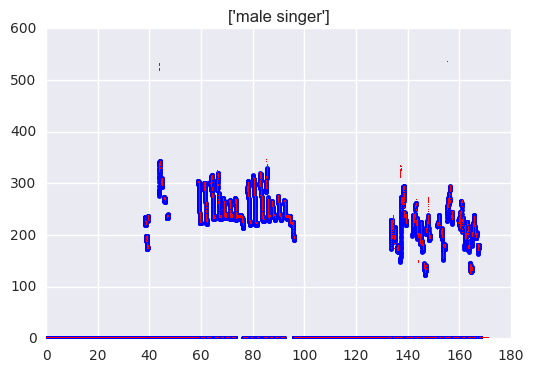

[OrderedDict([('Voicing Recall', 0.98469199557358911),
              ('Voicing False Alarm', 0.05660585959093422),
              ('Raw Pitch Accuracy', 0.9319439321283659),
              ('Raw Chroma Accuracy', 0.93526374031722614),
              ('Overall Accuracy', 0.93910278565010019)]),
 OrderedDict([('Voicing Recall', 0.98508866200967227),
              ('Voicing False Alarm', 0.030064690277842417),
              ('Raw Pitch Accuracy', 0.96225147770016117),
              ('Raw Chroma Accuracy', 0.96278882321332615),
              ('Overall Accuracy', 0.96795824548062637)])]

In [75]:
score_pyin_est(mtrack, activation_filter=True, make_plot=True, conf_thresh=1.0)

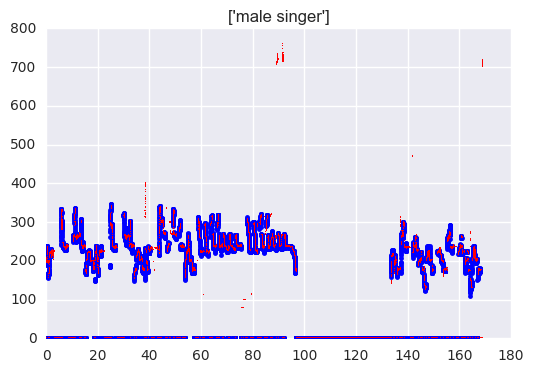

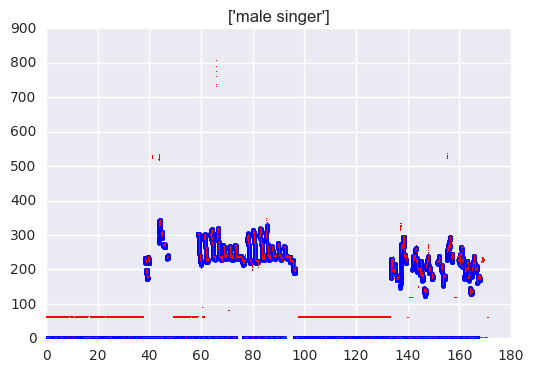

[OrderedDict([('Voicing Recall', 0.97985679439767093),
              ('Voicing False Alarm', 0.32308166409861327),
              ('Raw Pitch Accuracy', 0.90770320245495317),
              ('Raw Chroma Accuracy', 0.91195215988669442),
              ('Overall Accuracy', 0.77828851869772586)]),
 OrderedDict([('Voicing Recall', 0.98494962980944289),
              ('Voicing False Alarm', 0.70534506089309879),
              ('Raw Pitch Accuracy', 0.96310231824250514),
              ('Raw Chroma Accuracy', 0.96358781405510374),
              ('Overall Accuracy', 0.48501607272475888)])]

In [71]:
score_pyin_est(mtrack, activation_filter=False, make_plot=True, conf_thresh=0.5)